# NGC Kreek OAall GWAS
__Author__: Jesse Marks <br>
__Date__: November 7, 2018

This document revisits the data processing on the [Kreek](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/dataset.cgi?study_id=phs001109.v1.p1&phv=261899&phd=6837&pha=&pht=5447&phvf=&phdf=&phaf=&phtf=&dssp=1&consent=&temp=1) EA data set. The EA-specific GWAS results were inflated, so we will investigate this behavior more. The processing performed on these data follow the Heroin NIDA Genetics Consortium (NGC) Protocol. For any general or specific questions regarding this protocol, speak with Eric O. Johnson.

First order of business is to evaluate the PC distribution in the PCA plot.

## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* GNU bash version 4.1.2
* [PLINK v1.9 beta 3.45](https://www.cog-genomics.org/plink/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* R packages: MASS, moments
* [RVtests](https://render.githubusercontent.com/view/ipynb?commit=3bb8e661ad8b75af027ed2748133452ec251aaed&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f525449496e7465726e6174696f6e616c2f6271756163685f6e6f7465626f6f6b732f336262386536363161643862373561663032376564323734383133333435326563323531616165642f6865726f696e5f70726f6a6563742f646576656c6f702f32303138303131305f756873325f756873335f666f755f677761732e6970796e623f746f6b656e3d41664d79344e373237626e764465456f46535a697770346b48776246577964706b7335617570495a7741253344253344&nwo=RTIInternational%2Fbquach_notebooks&path=heroin_project%2Fdevelop%2F20180110_uhs2_uhs3_fou_gwas.ipynb&repository_id=105297875&repository_type=Repository)

## Variable information
### NGC Protocol Specifications
* OAall (coded 1 for all controls, 2 for OA cases)
* Sex (coded 1 for female, 2 for male)
* Any additional covariates (coded 1 for no, 2 for yes)
* Age (years)

### Kreek
#### genotype data (n=1200)
`wc -l aa_chr_all.fam` <br>
* 576 

`wc -l ea_chr_all.fam` <br>
* 624

#### phenotype data (n=1661)
Note, I will remap these to be consistent with the NGC protocol. 
[`affection_status`](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/variable.cgi?study_id=phs001109.v1.p1&phv=261892&phd=6837&pha=&pht=5447&phvf=1&phdf=&phaf=&phtf=&dssp=1&consent=&temp=1) <br>
* Case control status of the subject for opioid dependence
* 1 is opioid_dependence, 2 is no_opioid_dependence 
* 864 cases, 797 controls - total 1,661

[__OAall Variables__](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/dataset.cgi?study_id=phs001109.v1.p1&phv=261892&phd=6837&pha=&pht=5447&phvf=1&phdf=&phaf=&phtf=1&dssp=1&consent=&temp=1):
`Female (sex)` <br>
* 1 is male, 2 is female (Note, I will remap these to be consistent with the NGC protocol.)
* 1040 males, 616 females - total 1,656 (5 are missing sex data)

`Ageatint` <br>
* Age (integer) - total 1,661

**other variables**:
`opioid_dep      cocaine_dep     alcohol_dep   nicotine_dep     cannabis_dep    stimulant_dep   sedative_dep    other_dep       opioid_abuse    cocaine_abuse   alcohol_abuse   cannabis_abuse  stimulant_abuse        sedative_abuse  other_abuse`

# Download Data and Create Directory Structure

In [ ]:
## bash (EC2) ##

### create directory structure
genoD=/shared/data/studies/heroin/kreek/genotype/observed/final
gwasD=/shared/data/studies/heroin/kreek/gwas
phenoD=/shared/data/studies/heroin/kreek/phenotype
mdkir -p $genoD $gwasD $phenoD/{final,processing,unprocessed}

## Download data & unzip
aws s3 sync s3://rti-heroin/kreek/data/genotype/original $genoD
aws s3 sync s3://rti-heroin/kreek/data/phenotype/ $phenoD/

gzip -d $genoD/*

```
wc -l *fam
  576 aa_chr_all.fam
  624 ea_chr_all.fam
```

# Prepare files for rvTest
## Phenotype Data
Create phenotype files for rvtest. We follow the instructions of the NGC protocol distributed by Eric Johnson. This protocol mandates that we create a phenotype file and a covariate file in PED format. See the NGC protocol for more information on this format.
### Filter to variables of interest
For this first run, we will be performing a baseline GWAS.

#### _methods_kreek_phenotype_prep_20181109.py

In [ ]:
#### python ###
#
## contruct phenotype file (combine columns from phenotype files into one file)
## should have age, sex, case/control status
#
#phenoD = "/shared/data/studies/heroin/kreek/phenotype"
#infile = "{}/unprocessed/phs001109.v1.pht005447.v1.p1.c1.Addictive_Diseases_Subject_Phenotypes.DS-ADX-IRB-NPU.txt".format(phenoD)
#outfile = "{}/processing/kreek.phenotype.table".format(phenoD)
#
#with open(infile) as inF, open(outfile, 'w') as outF:
#    line = inF.readline()
#    while line[0:2] != '##': # skipping header
#        line = inF.readline()
#    header = inF.readline().split()
#    id_ndx = header.index('SUBJECT_ID')
#    age_ndx = header.index('age')
#    sex_ndx = header.index('sex')
#    heroin_ndx = header.index('opioid_dep')
#
#    index_list = [id_ndx, age_ndx, sex_ndx, heroin_ndx]
#
#    header = [header[i] for i in index_list]
#    header = '\t'.join(header)
#    outF.write(header + '\n')
#
#    line = inF.readline().split()
#    while line:
#        new_list = [line[i] for i in index_list]
#        #print(new_list)
#        new_line = '\t'.join(new_list)
#        outF.write(new_line + '\n')
#        line = inF.readline().split()
### end python    

In [ ]:
### R ###
phenoD <- "/shared/data/studies/heroin/kreek/phenotype/"
in_fname <- "unprocessed/phs001109.v1.pht005447.v1.p1.c1.Addictive_Diseases_Subject_Phenotypes.DS-ADX-IRB-NPU.txt"
out_fname <- "processing/kreek.phenotype_table"

phenoF <- read.table(paste(phenoD, in_fname, sep=""), sep='\t', header = T)
filtered_phen <- phenoF[c('SUBJECT_ID', 'age', 'sex', 'opioid_dep')]

write.table(filtered_phen, paste(phenoD, out_fname, sep=''), sep = '\t', quote=F, row.names=F)

# case controls
table(data$opioid_dep)
"""
  0   1
797 864
"""


Filter down to subjects with both genotype data (in \*fam plink file) and phenotype data.

In [ ]:
### Bash ###

# get IDs of subjects with genotype data
cut -d ' ' -f2 $genoD/ea_chr_all.fam > $phenoD/processing/kreek.ea.genotype.IDs
cut -d ' ' -f2 $genoD/aa_chr_all.fam > $phenoD/processing/kreek.aa.genotype.IDs

# if subject has genotype data, then keep
# AAs
awk 'NR==FNR{a[$1];next} FNR==1{print $0;next} FNR>=2{ if($1 in a) {print $0}}' \
    kreek.aa.genotype.IDs kreek.phenotype_table >\
    kreek.aa.phenotype_table.ID.age.sex.opioid_dep

# EAs
awk 'NR==FNR{a[$1];next} FNR==1{print $0;next} FNR>=2{ if($1 in a) {print $0}}' \
    kreek.ea.genotype.IDs kreek.phenotype_table >\
    kreek.ea.phenotype_table.ID.age.sex.opioid_dep
                    

wc -l *dep
"""
  577 kreek.aa.phenotype.table.ID.age.sex.opioid_dep
  625 kreek.ea.phenotype.table.ID.age.sex.opioid_dep
"""

Note, this removed the subjects with missing age data. Use the table() function in R to check for missing values. If they were missing, we would have removed those subjects.

### map case/control and sex
The NGC protocol requires:
* 1=female & 2=male
* 1=control & 2=case

In out data we have:

* 1=male & 2=female
* 0=control and 1=case

Therefore, we need to map these data appropriately.

In [ ]:
### Bash ###

# map sex code and affection_status (opioid_dep)
## AA
# sex
awk  'BEGIN {OFS= "\t"} NR>=2{ if ( $3 == "1" ) {$3=2} else {$3=1}} {print $0}' \
    kreek.aa.phenotype_table.ID.age.sex.opioid_dep >\
    kreek.aa.phenotype_table.ID.age.sex.opioid_dep.sex.mapped
# opioid_dep
awk 'BEGIN {OFS= "\t"} NR>=2{ if ( $4 == "0" ) {$4=1} else {$4=2}} {print $0}' \
    kreek.aa.phenotype_table.ID.age.sex.opioid_dep.sex.mapped > \
    kreek.aa.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped


## EA
awk  'BEGIN {OFS= "\t"} NR>=2{ if ( $3 == "1" ) {$3=2} else {$3=1}} {print $0}' \
    kreek.ea.phenotype_table.ID.age.sex.opioid_dep >\
    kreek.ea.phenotype_table.ID.age.sex.opioid_dep.sex.mapped
awk 'BEGIN {OFS= "\t"} NR>=2{ if ( $4 == "0" ) {$4=1} else {$4=2}} {print $0}' \
    kreek.ea.phenotype_table.ID.age.sex.opioid_dep.sex.mapped > \
    kreek.ea.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped

Before map:
```
 head *dep
==> kreek.aa.phenotype_table.ID.age.sex.opioid_dep <==
SUBJECT_ID      age     sex     opioid_dep
100002  34      1       0
100008  50      1       1
100027  52      1       1
100063  44      2       1
100070  52      2       0
100073  37      2       0
100085  36      2       1
100087  26      1       0
100101  34      1       0

==> kreek.ea.phenotype_table.ID.age.sex.opioid_dep <==
SUBJECT_ID      age     sex     opioid_dep
100004  56      1       1
100006  22      1       1
100007  22      2       1
100025  46      2       1
100032  45      2       0
100033  45      2       1
100047  46      1       1
100112  36      2       1
100149  36      2       0
```

After map:
```
head *l.mapped
SUBJECT_ID      age     sex     opioid_dep
100002  34      2       1
100008  50      2       2
100027  52      2       2
100063  44      1       2
100070  52      1       1
100073  37      1       1
100085  36      1       2
100087  26      2       1
100101  34      2       1

==> kreek.ea.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped <==
SUBJECT_ID      age     sex     opioid_dep
100004  56      2       2
100006  22      2       2
100007  22      1       2
100025  46      1       2
100032  45      1       1
100033  45      1       2
100047  46      2       2
100112  36      1       2
100149  36      1       1
 ```

In [ ]:
#copy to local machine 

cd /cygdrive/c/Users/jmarks/Desktop/Projects/heroin/ngc/kreek/20181113/phenotype
scp -i ~/.ssh/gwas_rsa ec2-user@54.90.227.178:/shared/data/studies/heroin/kreek/phenotype/processing/*l.mapped .

In [1]:
### R console ###
library(MASS)
options(repr.plot.width=10, repr.plot.height=17)
# note that I copied over the phenotype data to my local machine to produce the plots
setwd('C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181113/phenotype')

ea.data <- read.table("kreek.ea.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped", 
                                     header = T, colClasses =  rep("double",  4))
aa.data <- read.table("kreek.aa.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped", 
                                     header = T, colClasses =  rep("double",  4))

print("EA:1 is female 2 is male.")
table(ea.data$sex)
print("EA: age")
table(ea.data$age)
print("EA: Case/control - 1 is control & 2 is case")
table(ea.data$opioid_dep)
print("AA:1 is female 2 is male.")
table(aa.data$sex)
print("AA: Age")
table(aa.data$age)
print("AA:Case/control - 1 is control & 2 is case")
table(aa.data$opioid_dep)

[1] "EA:1 is female 2 is male."



  1   2 
239 385 

[1] "EA: age"



17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
 7  7 18  9 14 18 14 19 10  8 17 16 14 16 10 18 12 12  5 13 16  8 10 11 11 12 
43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 
14 17 18 25 24 25 17 10 14 15 10 16 16 11 10  8  4 12  6  4  4  7  1  2  4  1 
69 70 71 
 1  1  2 

[1] "EA: Case/control - 1 is control & 2 is case"



  1   2 
216 408 

[1] "AA:1 is female 2 is male."



  1   2 
206 370 

[1] "AA: Age"



17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
 1  4  8  2  8  8  5  5 14  7  7  9  6  4 13  6 10 12  7  8 12 17 13 18 18 28 
43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 67 68 69 71 
24 31 25 19 19 25 28 21  8 16 10 15 10  8 12 17 11  7  8  2  2  2  2  1  1  1 
78 
 1 

[1] "AA:Case/control - 1 is control & 2 is case"



  1   2 
370 206 

### PCA (EIGENSTRAT)
To obtain principal component covariates to use in the GWAS statistical model, EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group. Usually a GRCh37 plus strand check is implemented, as well as a monomorphic SNP filter and discordant allele flip. Since this was already done for data in preparation for haplotype phasing, the haplotype phasing input PLINK files will be used. 

**Note**: In addition to these aforementioned data processing steps, ambiguous SNPs identified by reference panel frequency differences in the discordant allele checks were also removed prior to phasing.

#### Remove high-LD region variants

In [ ]:
### Bash (EC2 console)###

eig=/shared/data/studies/heroin/kreek/eig
mkdir -p $eig

for ancestry in {ea,aa};do
    # Generate list of variants in known high-LD regions
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }'\
    $genoD/${ancestry}_chr_all.bim > $eig/${ancestry}.high_ld_regions.remove
done
            

# Remove SNPs in known high-LD regions
for ancestry in {ea,aa};do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genoD/${ancestry}_chr_all \
        --exclude $eig/${ancestry}.high_ld_regions.remove \
        --make-bed \
        --out $eig/${ancestry}_high_ld_regions_removed
done

 wc -l *bim
"""
 491527 aa_high_ld_regions_removed.bim
 499525 ea_high_ld_regions_removed.bim
"""

#### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
### EC2 console ###

study=kreek

for ancestry in {ea,aa};do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name $study.${ancestry}.chr${chr}.ld_prune \
            --script_prefix $eig/${ancestry}_chr${chr}_ld_prune \
            --mem 3 \
            --nslots 2 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 3000 \
                --bfile $eig/${ancestry}_high_ld_regions_removed \
                --indep-pairwise 1500 150 0.2 \
                --chr ${chr} \
                --out $eig/${ancestry}_chr${chr}_ld_pruned
    done
done

# Merge *prune.in files
for ancestry in {aa,ea};do
    cat ${ancestry}_chr*_ld_pruned.prune.in > ${ancestry}_chr_all_ld_pruned.prune.in
done


# Create new PLINK filesets with only lD pruned variants
for ancestry in {aa,ea};do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}_high_ld_regions_removed \
        --extract ${ancestry}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out ${ancestry}_ld_pruned
done

# Clean up
for ancestry in {aa,ea};do
    rm *${ancestry}*ld_pruned.{prune.in,prune.out,log}
    rm *${ancestry}*ld_prune*qsub*
    rm *${ancestry}*high_ld_regions*
    rm *${ancestry}*chr23_ld_pruned.hh
done

""" wc -l *bim
  218324 aa_ld_pruned.bim
  137845 ea_ld_pruned.bim
"""

#### Rename BIM/FAM file IDs
BIM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. FAM file IDs are treated similarly.

In [ ]:
### EC2 console ###

cd $eig
study=kreek

# Count ID lengths greater than 39 characters
# an example of an rsID that is too long is the following:
# rs141233280:245974067:GAAAGACGCACTTTTC:G
for ancestry in {aa,ea};do
    awk '{ if(length($1)+length($2)>39){print $2} }' ${ancestry}_ld_pruned.fam | wc -l
    awk '{ if(length($2)>39){print $2} }' ${ancestry}_ld_pruned.bim | wc -l
done
# output is
"""
0
2
0
1
"""


# Rename BIM file IDs
for ancestry in {aa,ea};do
    awk '{$2="ID_"NR; print $0}' ${ancestry}_ld_pruned.bim \
        > ${ancestry}_ld_pruned_id_renamed.bim
done

## Rename FAM file IDs
#awk '{$1="ID_"NR; print $0}' ${ancestry}_ld_pruned.fam > ${ancestry}_ld_pruned_id_renamed.fam
#done

**Note** we did not have to rename the FAM files for this case.

#### Assign Cases and Controls
Modify the fam file to include case/control status. According to PLINK,

`Phenotype value ('1' = control, '2' = case, '-9'/'0'/non-numeric = missing data if case/control)`

The NGC protocol is consistent with this assignment.

In [ ]:
# EC2 command line #
cd $eig

tail -n +2 $phenoD/processing/kreek.aa.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped |\
    awk '{ if ($4==1) {print $1}}' > $eig/aa.controls.ids

tail -n +2 $phenoD/processing/kreek.ea.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped |\
    awk '{ if ($4==1) {print $1}}' > $eig/ea.controls.ids

# Modify FAM file to include case/control status
awk 'NR==FNR{map[$1]; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
    $eig/aa.controls.ids $eig/aa_ld_pruned.fam > $eig/aa_ld_pruned.case+control.mapped.fam
awk 'NR==FNR{map[$1]; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
    $eig/ea.controls.ids $eig/ea_ld_pruned.fam > $eig/ea_ld_pruned.case+control.mapped.fam

#### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT `bin` directory should be part of the PATH variable.

The `smartpca.pl` program documentation is shown below:

DOCUMENTATION of `smartpca.pl` program:

This program calls the smartpca program (see ../POPGEN/README). 
For this to work, the bin directory containing smartpca MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
### EC2 console ###
cd $eig
mkdir $eig/results

study=kreek

# Run smartpca
for ancestry in {ea,aa}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.${ancestry}_smartpca \
        --script_prefix $eig/smartpca.$study.${ancestry} \
        --mem 7.5 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
            -i $eig/${ancestry}_ld_pruned.bed \
            -a $eig/${ancestry}_ld_pruned_id_renamed.bim \
            -b $eig/${ancestry}_ld_pruned.case+control.mapped.fam \
            -o $eig/results/${ancestry}_ld_pruned.pca \
            -p $eig/results/${ancestry}_ld_pruned.plot \
            -e $eig/results/${ancestry}_ld_pruned.eval \
            -l $eig/results/${ancestry}_ld_pruned.pca.log \
            -m 0
done

#### View PCs from EIGENSTRAT
Copy results over to local machine.

In [1]:
#cd /cygdrive/c/Users/jmarks/Desktop/Projects/heroin/ngc/kreek/20181113/eig
#scp -i ~/.ssh/gwas_rsa ec2-user@54.90.227.178:/shared/data/studies/heroin/kreek/eig/results/* .

### R console ###
# Load PCA data
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181113/eig/")
options(stringsAsFactors = F)
ea.evec <- read.table("ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
ea.evec[,1:5]
aa.evec <- read.table("aa_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
aa.evec[,6:11]

,V2,V3,V4,V5,V6
0:100004,0.0047,-0.0015,-0.0179,-0.0152,0.0089
0:100006,0.0289,0.0071,0.0016,0.0023,0.0039
0:100007,0.0334,0.0013,-0.0087,-0.0030,-0.0048
0:100025,-0.0015,0.0056,-0.0075,-0.0447,0.0142
0:100032,-0.0760,0.0158,-0.0029,0.0079,-0.0013
0:100033,0.0207,0.0091,-0.0081,0.0066,-0.0060
0:100047,0.0281,0.0109,-0.0135,-0.0012,-0.0102
0:100112,0.0318,0.0027,-0.0023,0.0089,-0.0096
0:100149,0.0350,0.0052,-0.0025,0.0013,-0.0175
0:100191,0.0290,0.0034,-0.0013,-0.0172,0.0044


,V7,V8,V9,V10,V11,V12
0:100002,-0.0102,0.0065,-0.0076,-0.0066,-0.0299,Control
0:100008,-0.0542,0.0708,-0.0063,-0.0151,0.0142,Case
0:100027,0.0089,-0.0253,-0.0227,0.0215,-0.0033,Case
0:100063,-0.0087,0.0040,0.0052,-0.0025,-0.0065,Case
0:100070,0.0065,-0.0058,-0.0005,-0.0162,-0.0414,Control
0:100073,-0.0015,0.0039,-0.0067,0.0023,-0.0039,Control
0:100085,0.0189,0.0229,-0.0098,-0.0070,0.0113,Case
0:100087,0.0380,-0.0493,0.0203,0.0202,0.0282,Control
0:100101,0.0082,-0.0095,-0.0103,0.0169,-0.0096,Control
0:100119,-0.0496,0.0764,-0.0136,0.0073,0.0034,Case


##### EA

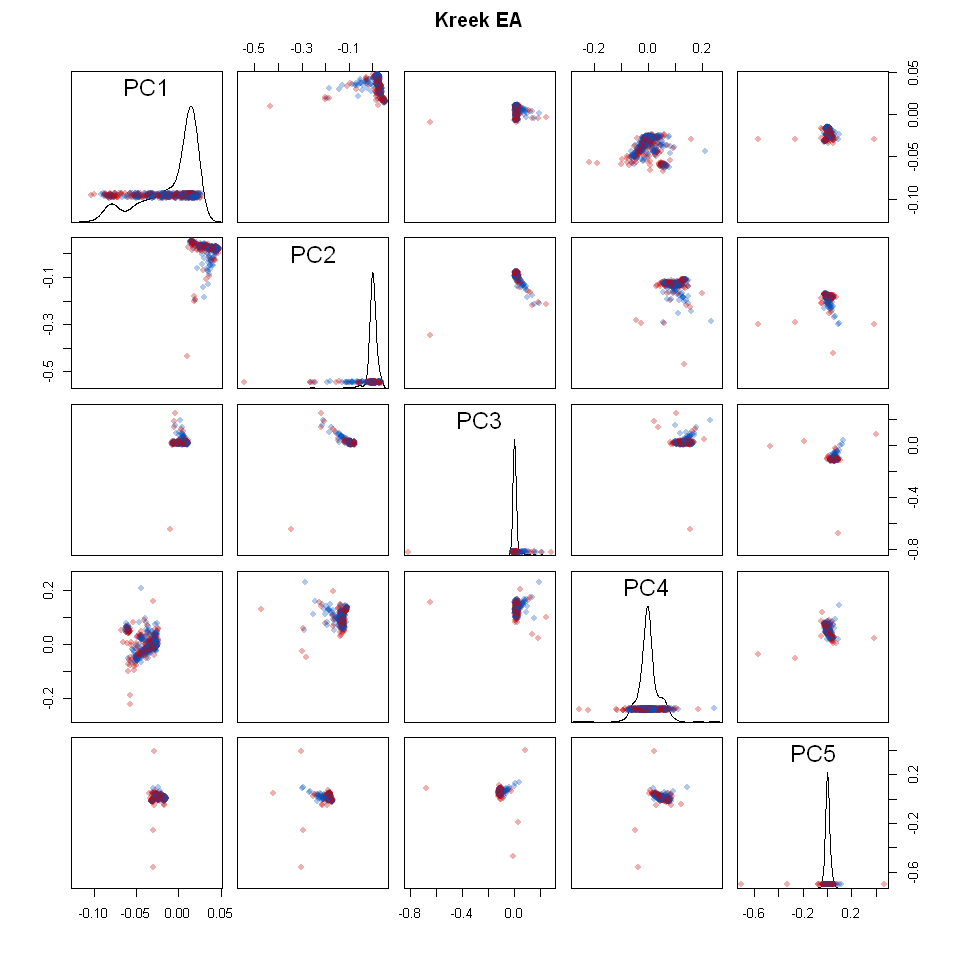

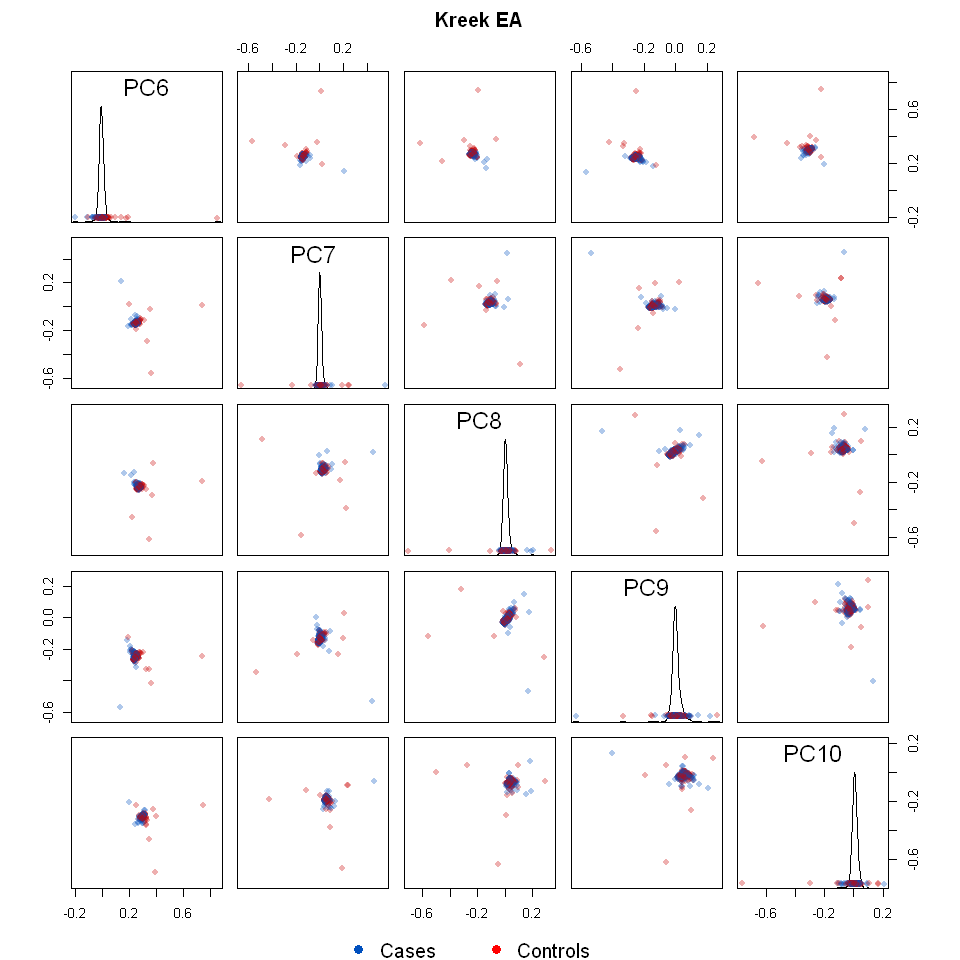

In [2]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
sample.names <- ea.evec[,11]
label.colors <- rep(NA, length(sample.names))
label.colors[grepl(x=sample.names, pattern="Case", ignore.case=T)] <- rgb(0,80,190,80, maxColorValue=255) #blue
label.colors[grepl(x=sample.names, pattern="Control", ignore.case=T)] <- rgb(200,0,0,80, maxColorValue=255) #red
legend.cols <- c(rgb(0,80,190,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255))

###label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek EA", cex.main=1)
legend("bottom", c("Cases", "Controls"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)


#--------------------------------------------------------------------------------


##### AA

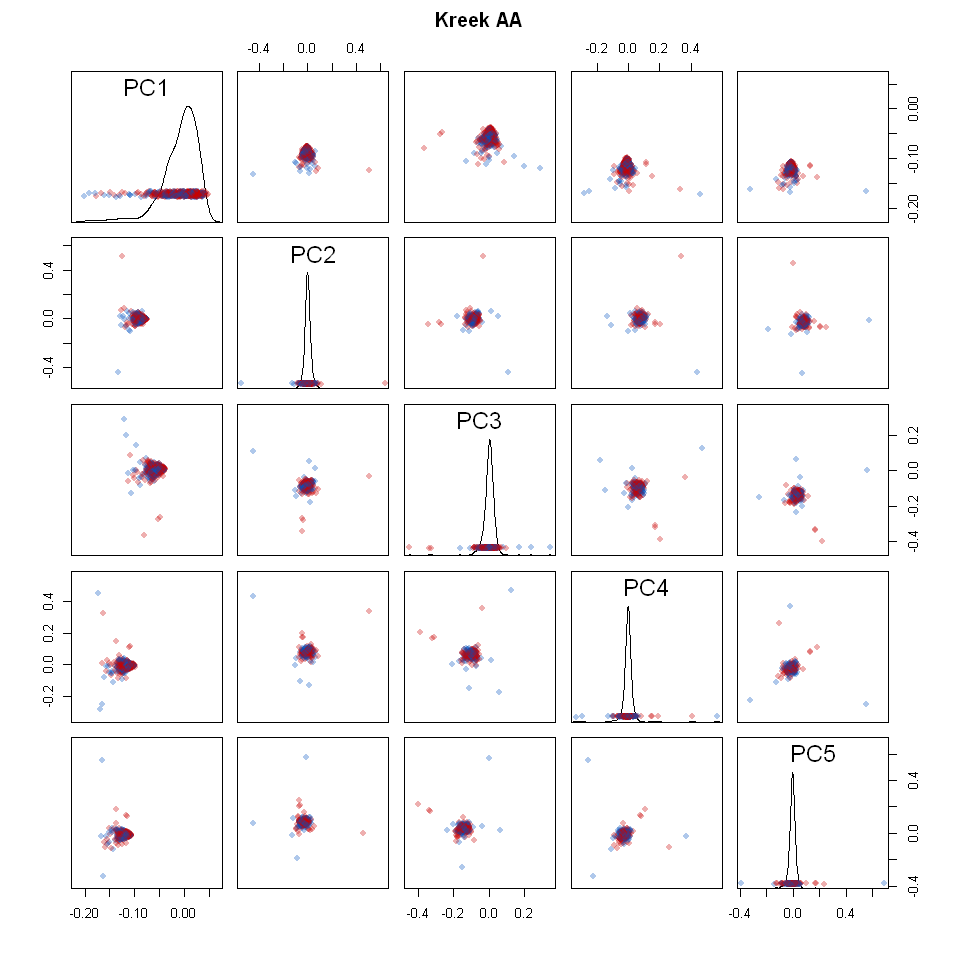

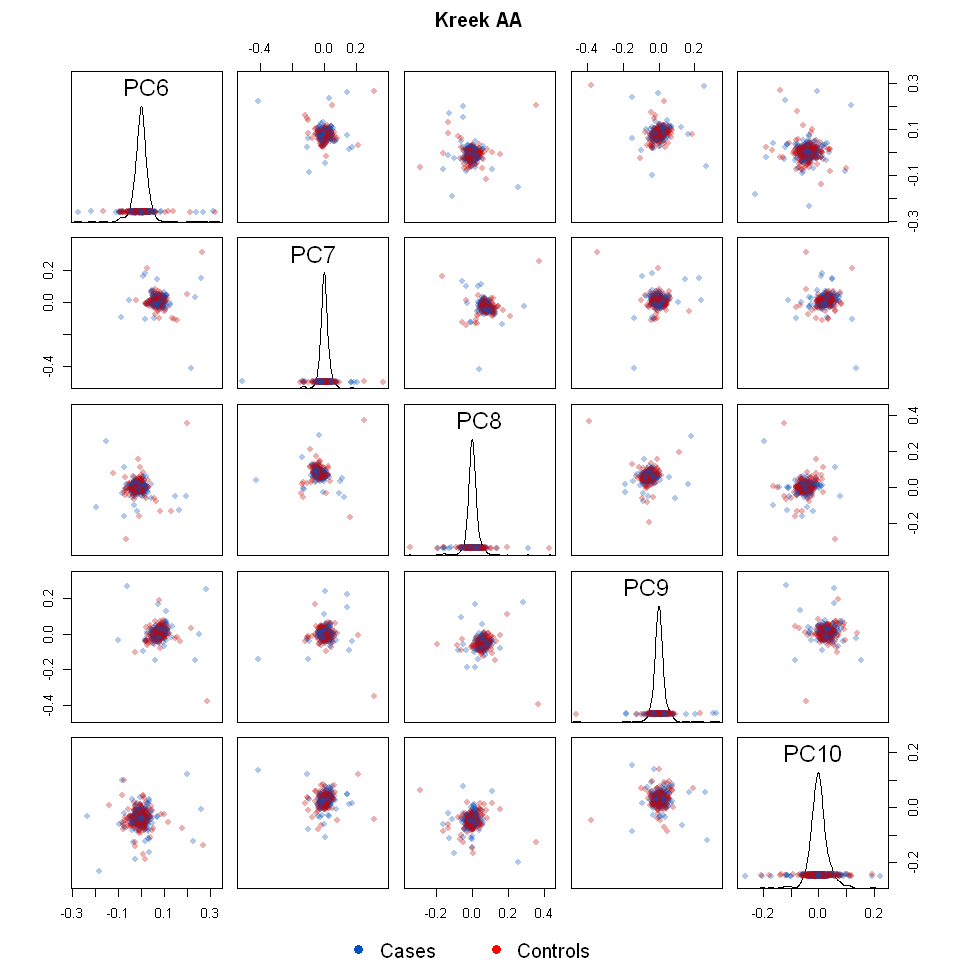

In [3]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
sample.names <- aa.evec[,11]
label.colors <- rep(NA, length(sample.names))
label.colors[grepl(x=sample.names, pattern="Case", ignore.case=T)] <- rgb(0,80,190,80, maxColorValue=255) #blue
label.colors[grepl(x=sample.names, pattern="Control", ignore.case=T)] <- rgb(200,0,0,80, maxColorValue=255) #red
legend.cols <- c(rgb(0,80,190,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255))

###label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek AA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek AA", cex.main=1)
legend("bottom", c("Cases", "Controls"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)


#--------------------------------------------------------------------------------


#### Extract Eigenvectors

In [ ]:
### EC2 console ###
#cd $eig/results

# Grab top 10 eigenvectors from PCA 
for ancestry in {ea,aa};do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > ${ancestry}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 ${ancestry}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> ${ancestry}_ld_pruned_top10_eigenvecs.txt
done

# copy to local
#scp -i ~/.ssh/gwas_rsa ec2-user@54.90.227.178:/shared/data/studies/heroin/gwas/kreek/results/* .

### EA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.
Make PED format phenotype and covariate file according to the NGC protocol.

#### Create PED files
The covariates we want to include in this baseline GWAS are age, sex, and some of the most influential PCs. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain  ∼75%  of the variance.

In [6]:
#mkdir /cygdrive/c/Users/jmarks/Desktop/Projects/heroin/ngc/kreek/20181113/phenotype/final

### R (local) ###

## Phen file
#------------------------------------------------------------------------------------------
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181113/phenotype")
p.data <- "kreek.ea.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped"
pheno.data.ea <- read.csv(p.data, sep = "\t", header = TRUE, stringsAsFactors = F, 
                       colClasses=c("integer", "double", "integer", "integer"))

head(pheno.data.ea)
pca.data.ea <- read.csv("../eig/ea_ld_pruned_top10_eigenvecs.txt",
                     sep = " " , header=T, colClasses=c(rep("character",times=2), rep("double",times = 10)))

num.subjects.ea <- length(pca.data.ea[,1])

ped.file.ea <- data.frame(matrix(ncol = 6, nrow = num.subjects.ea))
colnames(ped.file.ea) <- c("fid", "iid", "patid", "matid", "sex",  "oaall")
ped.file.ea[,1] <- pca.data.ea[,1]
ped.file.ea[,2] <- pca.data.ea[,2]

# map loop (goal to fill in sex and oaall data on ped.file.ea from the pheno.data.ea)
for (i in 1:num.subjects.ea){
    # character string of the iid without quotations 
    key <- noquote(ped.file.ea[i,2])
    
    # match returns a vector of the positions of (first) matches of its first argument in its second. 
    my_match <- match(key, pheno.data.ea[,1])
    
    ped.file.ea[i,5] <- pheno.data.ea[my_match,3] # sex
    ped.file.ea[i,6] <- pheno.data.ea[my_match,4] # oaall
    
} # end i loop

head(ped.file.ea)
write.table(ped.file.ea[,1:6], "kreek_EUR_phen.ped", sep = "\t", row.names = F, quote=F)


#----------------------------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude oaall data)
col.names.ea <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.ea <- length(col.names.ea)
covar.data.ea <- data.frame(matrix(ncol = num.columns.ea, nrow = num.subjects.ea))
names(covar.data.ea) <- col.names.ea

num.covs.ea <- length(ped.file.ea) - 1
covar.data.ea[,1:num.covs.ea] <- ped.file.ea[,1:num.covs.ea]
covar.data.ea[,num.covs.ea+1] <- pheno.data.ea[,2] # age 

covar.data.ea[,(num.covs.ea+2):length(col.names.ea)] <- pca.data.ea[,3:length(pca.data.ea)]

head(covar.data.ea)
length(covar.data.ea[,1])

write.table(covar.data.ea, "kreek_EUR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

SUBJECT_ID,age,sex,opioid_dep
100004,56,2,2
100006,22,2,2
100007,22,1,2
100025,46,1,2
100032,45,1,1
100033,45,1,2


fid,iid,patid,matid,sex,oaall
0,100004,NA,NA,2,2
0,100006,NA,NA,2,2
0,100007,NA,NA,1,2
0,100025,NA,NA,1,2
0,100032,NA,NA,1,1
0,100033,NA,NA,1,2


fid,iid,patid,matid,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,100004,NA,NA,2,56,0.0047,-0.0015,-0.0179,-0.0152,0.0089,0.0023,-0.0160,-0.0168,-0.0062,-0.0003
0,100006,NA,NA,2,22,0.0289,0.0071,0.0016,0.0023,0.0039,0.0028,-0.0077,-0.0016,0.0042,0.0014
0,100007,NA,NA,1,22,0.0334,0.0013,-0.0087,-0.0030,-0.0048,-0.0061,-0.0017,-0.0205,-0.0172,-0.0002
0,100025,NA,NA,1,46,-0.0015,0.0056,-0.0075,-0.0447,0.0142,0.0079,-0.0121,0.0024,0.0132,0.0148
0,100032,NA,NA,1,45,-0.0760,0.0158,-0.0029,0.0079,-0.0013,0.0142,0.0210,-0.0068,0.0191,0.0105
0,100033,NA,NA,1,45,0.0207,0.0091,-0.0081,0.0066,-0.0060,-0.0016,-0.0111,-0.0054,-0.0027,-0.0012


[1] 624

In [7]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181113/phenotype/")
options(stringsAsFactors=F)
ea.cov.data <- read.delim("kreek_EUR_cov.ped", header=T, sep="\t")
ea.phen.data <- read.delim("kreek_EUR_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "oaall"
pc.names <- paste0("PC", 1:10)
ea.data <- merge(x=ea.phen.data[,c("iid",phen.name)], y=ea.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(ea.data)

iid,oaall,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
100004,2,0.0047,-0.0015,-0.0179,-0.0152,0.0089,0.0023,-0.0160,-0.0168,-0.0062,-0.0003
100006,2,0.0289,0.0071,0.0016,0.0023,0.0039,0.0028,-0.0077,-0.0016,0.0042,0.0014
100007,2,0.0334,0.0013,-0.0087,-0.0030,-0.0048,-0.0061,-0.0017,-0.0205,-0.0172,-0.0002
100025,2,-0.0015,0.0056,-0.0075,-0.0447,0.0142,0.0079,-0.0121,0.0024,0.0132,0.0148
100032,1,-0.0760,0.0158,-0.0029,0.0079,-0.0013,0.0142,0.0210,-0.0068,0.0191,0.0105
100033,2,0.0207,0.0091,-0.0081,0.0066,-0.0060,-0.0016,-0.0111,-0.0054,-0.0027,-0.0012


#### Regression analysis
We use a regression model of the general structure:

$$\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}$$

In [8]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.ea <- lm(formula=as.formula(model.str), data=ea.data)

# Get sequential (type I) sum of squares
anova.ea <- anova(lm.fit.ea)

# Calculate percent variance explained and sort
ea.pve <- cbind(anova.ea[pc.names,], 
                PVE=round(anova.ea[pc.names, "Mean Sq"]/sum(anova.ea[pc.names, "Mean Sq"])*100, digits=2))
ea.pve.sorted <- ea.pve[order(ea.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ EA group ================")
summary(lm.fit.ea)
ea.pve.sorted

MODEL FORMULA:

 oaall ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EA group ================


Call:
lm(formula = as.formula(model.str), data = ea.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8174 -0.5694  0.2768  0.3087  0.6774 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.653845   0.018565  89.082  < 2e-16 ***
PC1          2.319669   0.463759   5.002 7.42e-07 ***
PC2          0.005811   0.463737   0.013  0.99001    
PC3          0.436285   0.463780   0.941  0.34722    
PC4         -0.221120   0.463741  -0.477  0.63366    
PC5          0.700825   0.463780   1.511  0.13127    
PC6         -1.400750   0.463755  -3.020  0.00263 ** 
PC7          0.359996   0.463741   0.776  0.43788    
PC8          0.880168   0.463763   1.898  0.05818 .  
PC9          0.350988   0.463755   0.757  0.44944    
PC10         0.536596   0.463743   1.157  0.24768    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4638 on 613 degrees of freedom
Multiple R-squared:  0.06648,	Adjusted R-squared:  0.05125

,Df,Sum Sq,Mean Sq,F value,Pr(>F),PVE
PC1,1,5.381453e+00,5.381453e+00,2.502120e+01,7.415170e-07,57.31
PC6,1,1.962147e+00,1.962147e+00,9.123053e+00,2.629166e-03,20.90
PC8,1,7.746886e-01,7.746886e-01,3.601935e+00,5.818190e-02,8.25
PC5,1,4.911095e-01,4.911095e-01,2.283426e+00,1.312780e-01,5.23
PC10,1,2.879598e-01,2.879598e-01,1.338876e+00,2.476829e-01,3.07
PC3,1,1.903156e-01,1.903156e-01,8.848772e-01,3.472399e-01,2.03
PC7,1,1.295758e-01,1.295758e-01,6.024662e-01,4.379380e-01,1.38
PC9,1,1.231802e-01,1.231802e-01,5.727295e-01,4.494671e-01,1.31
PC4,1,4.890283e-02,4.890283e-02,2.273750e-01,6.336471e-01,0.52
PC2,1,3.401161e-05,3.401161e-05,1.581378e-04,9.899707e-01,0.00


#### Percent Variance Explained Visualization

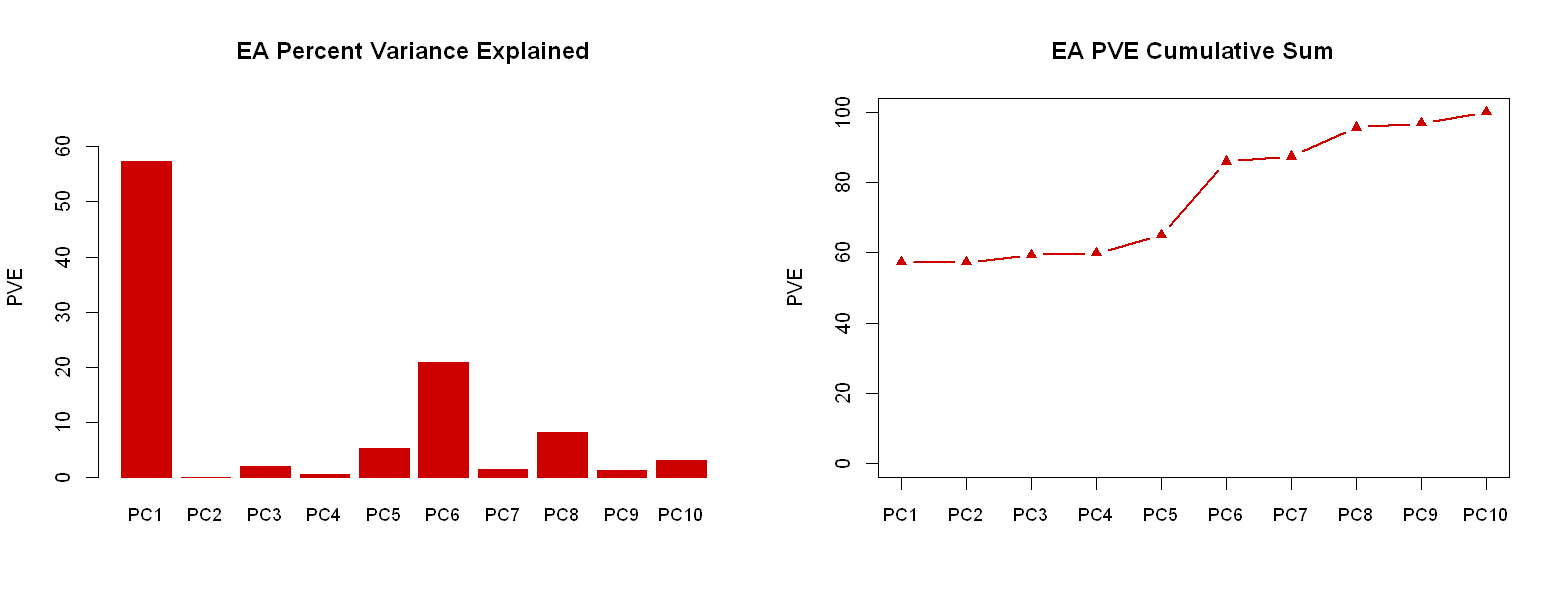

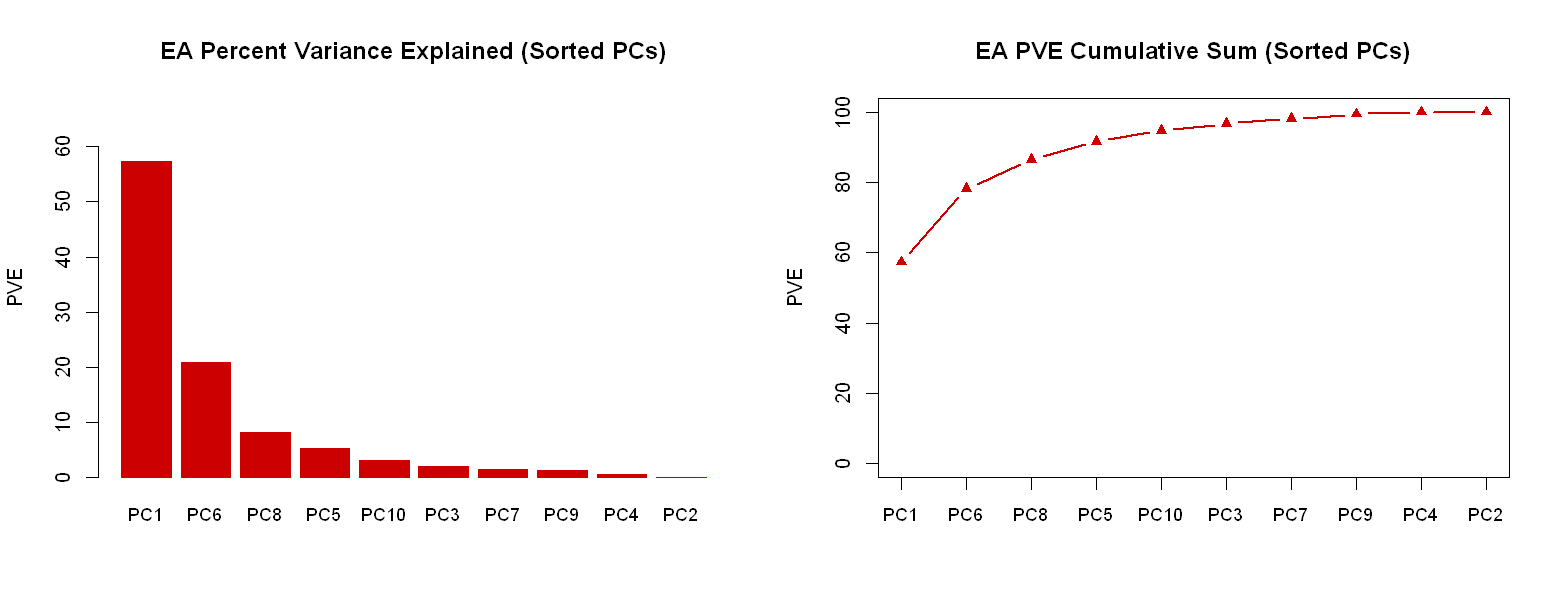

In [9]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.ea = c(0, max(ea.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=ea.pve$PVE, names.arg=rownames(ea.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, 
        main="EA Percent Variance Explained", ylab="PVE")
plot(cumsum(ea.pve$PVE), type="b", main="EA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=ea.pve.sorted$PVE, names.arg=rownames(ea.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, main="EA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(ea.pve.sorted$PVE), type="b", main="EA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve.sorted), cex.axis=cex.factor)

Based on these results we will use PC1,PC6. These PCs explain ~76% of the variance. 

### AA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.
Make PED format phenotype and covariate file according to the NGC protocol.

#### Create PED files
The covariates we want to include in this baseline GWAS are age, sex, and some of the most influential PCs. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain  ∼75%  of the variance.

In [10]:
### R (local) ###

## Phen file
#------------------------------------------------------------------------------------------
setwd('C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181113/phenotype')
p.data <- "kreek.aa.phenotype_table.ID+age+sex+opioid_dep.sex+case_control.mapped"
pheno.data.aa <- read.csv(p.data, sep = "\t", header = T, stringsAsFactors = F, 
                       colClasses=c("integer", "double", "integer", "integer"))

head(pheno.data.aa)
pca.data.aa <- read.csv("../eig/aa_ld_pruned_top10_eigenvecs.txt",
                     sep = " " , header=T, colClasses=c(rep("character",times=2), rep("double",times = 10)))

num.subjects.aa <- length(pca.data.aa[,1])

ped.file.aa <- data.frame(matrix(ncol = 6, nrow = num.subjects.aa))
colnames(ped.file.aa) <- c("fid", "iid", "patid", "matid", "sex",  "oaall")
ped.file.aa[,1] <- pca.data.aa[,1]
ped.file.aa[,2] <- pca.data.aa[,2]

# map loop (goal to fill in sex and oaall data on ped.file.aa from the pheno.data.aa)
for (i in 1:num.subjects.aa){
    # character string of the iid without quotations 
    key <- noquote(ped.file.aa[i,2])
    
    # match returns a vector of the positions of (first) matches of its first argument in its second. 
    my_match <- match(key, pheno.data.aa[,1])
    
    ped.file.aa[i,5] <- pheno.data.aa[my_match,3] # sex
    ped.file.aa[i,6] <- pheno.data.aa[my_match,4] # oaall
    
} # end i loop

head(ped.file.aa)
write.table(ped.file.aa[,1:6], "kreek_AFR_phen.ped", sep = "\t", row.names = F, quote=F)


#----------------------------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude oaall data)
col.names.aa <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.aa <- length(col.names.aa)
covar.data.aa <- data.frame(matrix(ncol = num.columns.aa, nrow = num.subjects.aa))
names(covar.data.aa) <- col.names.aa

num.covs.aa <- length(ped.file.aa) - 1
covar.data.aa[,1:num.covs.aa] <- ped.file.aa[,1:num.covs.aa]
covar.data.aa[,num.covs.aa+1] <- pheno.data.aa[,2] # age 

covar.data.aa[,(num.covs.aa+2):length(col.names.aa)] <- pca.data.aa[,3:length(pca.data.aa)]

head(covar.data.aa)
length(covar.data.aa[,1])

write.table(covar.data.aa, "kreek_AFR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

SUBJECT_ID,age,sex,opioid_dep
100002,34,2,1
100008,50,2,2
100027,52,2,2
100063,44,1,2
100070,52,1,1
100073,37,1,1


fid,iid,patid,matid,sex,oaall
0,100002,NA,NA,2,1
0,100008,NA,NA,2,2
0,100027,NA,NA,2,2
0,100063,NA,NA,1,2
0,100070,NA,NA,1,1
0,100073,NA,NA,1,1


fid,iid,patid,matid,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,100002,NA,NA,2,34,0.0329,-0.0116,0.0008,-0.0097,-0.0011,-0.0102,0.0065,-0.0076,-0.0066,-0.0299
0,100008,NA,NA,2,50,-0.0247,0.0351,-0.0415,-0.0114,-0.0058,-0.0542,0.0708,-0.0063,-0.0151,0.0142
0,100027,NA,NA,2,52,-0.0168,0.0031,0.0498,-0.0325,0.0067,0.0089,-0.0253,-0.0227,0.0215,-0.0033
0,100063,NA,NA,1,44,0.0386,-0.0059,0.0087,0.0005,-0.0123,-0.0087,0.0040,0.0052,-0.0025,-0.0065
0,100070,NA,NA,1,52,-0.0172,-0.0110,0.0086,-0.0386,0.0312,0.0065,-0.0058,-0.0005,-0.0162,-0.0414
0,100073,NA,NA,1,37,0.0408,0.0126,0.0015,0.0092,-0.0081,-0.0015,0.0039,-0.0067,0.0023,-0.0039


[1] 576

In [11]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181113/phenotype")
options(stringsAsFactors=F)
aa.cov.data <- read.delim("kreek_AFR_cov.ped", header=T, sep="\t")
aa.phen.data <- read.delim("kreek_AFR_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "oaall"
pc.names <- paste0("PC", 1:10)
aa.data <- merge(x=aa.phen.data[,c("iid",phen.name)], y=aa.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(aa.data)

iid,oaall,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
100002,1,0.0329,-0.0116,0.0008,-0.0097,-0.0011,-0.0102,0.0065,-0.0076,-0.0066,-0.0299
100008,2,-0.0247,0.0351,-0.0415,-0.0114,-0.0058,-0.0542,0.0708,-0.0063,-0.0151,0.0142
100027,2,-0.0168,0.0031,0.0498,-0.0325,0.0067,0.0089,-0.0253,-0.0227,0.0215,-0.0033
100063,2,0.0386,-0.0059,0.0087,0.0005,-0.0123,-0.0087,0.0040,0.0052,-0.0025,-0.0065
100070,1,-0.0172,-0.0110,0.0086,-0.0386,0.0312,0.0065,-0.0058,-0.0005,-0.0162,-0.0414
100073,1,0.0408,0.0126,0.0015,0.0092,-0.0081,-0.0015,0.0039,-0.0067,0.0023,-0.0039


#### Regression analysis
We use a regression model of the general structure:

$$\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}$$

In [12]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.aa <- lm(formula=as.formula(model.str), data=aa.data)

# Get sequential (type I) sum of squares
anova.aa <- anova(lm.fit.aa)

# Calculate percent variance explained and sort
aa.pve <- cbind(anova.aa[pc.names,], 
                PVE=round(anova.aa[pc.names, "Mean Sq"]/sum(anova.aa[pc.names, "Mean Sq"])*100, digits=2))
aa.pve.sorted <- aa.pve[order(aa.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ AA group ================")
summary(lm.fit.aa)
aa.pve.sorted

MODEL FORMULA:

 oaall ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ AA group ================


Call:
lm(formula = as.formula(model.str), data = aa.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7094 -0.3533 -0.3085  0.6136  0.7293 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.35764    0.01993  68.118  < 2e-16 ***
PC1         -1.38669    0.47832  -2.899  0.00389 ** 
PC2         -0.57323    0.47833  -1.198  0.23127    
PC3          0.44416    0.47835   0.929  0.35353    
PC4         -0.34181    0.47833  -0.715  0.47516    
PC5         -0.15154    0.47833  -0.317  0.75151    
PC6          0.28945    0.47836   0.605  0.54536    
PC7          0.37615    0.47834   0.786  0.43199    
PC8         -0.06059    0.47830  -0.127  0.89925    
PC9          0.38600    0.47833   0.807  0.42002    
PC10         0.28787    0.47834   0.602  0.54755    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4783 on 565 degrees of freedom
Multiple R-squared:  0.02305,	Adjusted R-squared:  0.005754 
F-statist

,Df,Sum Sq,Mean Sq,F value,Pr(>F),PVE
PC1,1,1.923105443,1.923105443,8.40486463,0.00388758,63.06
PC2,1,0.328556553,0.328556553,1.43594485,0.23129908,10.77
PC3,1,0.197228976,0.197228976,0.86198229,0.35358101,6.47
PC9,1,0.149004309,0.149004309,0.65121809,0.42001709,4.89
PC7,1,0.141487776,0.141487776,0.61836734,0.43198432,4.64
PC4,1,0.116854388,0.116854388,0.51070799,0.47512769,3.83
PC6,1,0.083790428,0.083790428,0.36620312,0.54532418,2.75
PC10,1,0.082866433,0.082866433,0.36216483,0.54754780,2.72
PC5,1,0.022954501,0.022954501,0.10032184,0.75156075,0.75
PC8,1,0.003672028,0.003672028,0.01604847,0.89923672,0.12


#### Percent Variance Explained Visualization

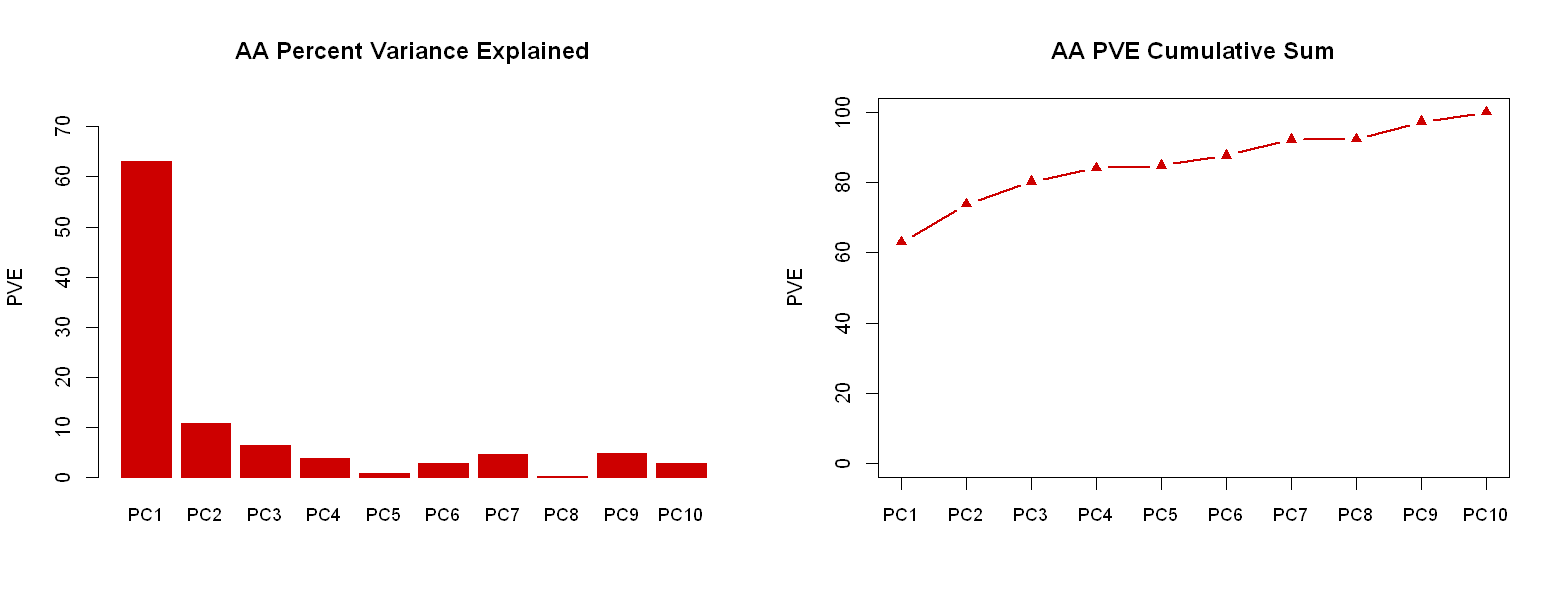

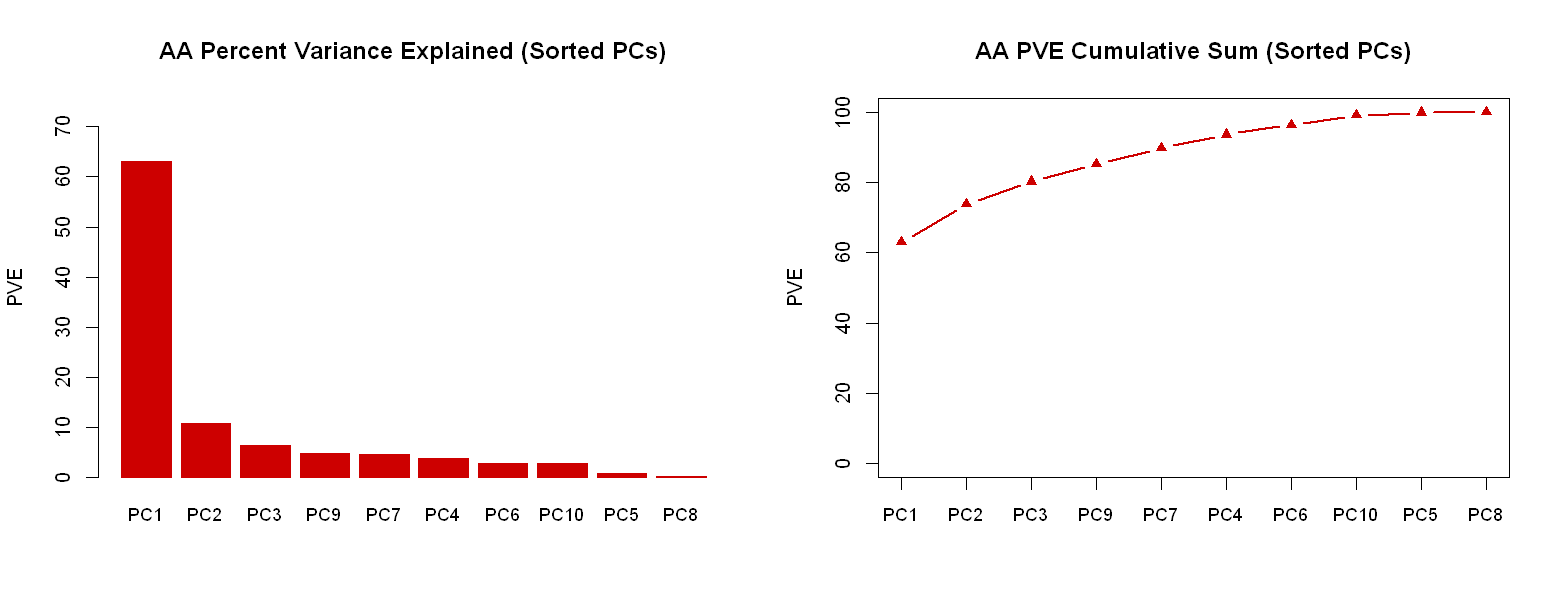

In [13]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.aa = c(0, max(aa.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=aa.pve$PVE, names.arg=rownames(aa.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.aa, 
        main="AA Percent Variance Explained", ylab="PVE")
plot(cumsum(aa.pve$PVE), type="b", main="AA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(aa.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=aa.pve.sorted$PVE, names.arg=rownames(aa.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.aa, main="AA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(aa.pve.sorted$PVE), type="b", main="AA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(aa.pve.sorted), cex.axis=cex.factor)

Based on these results we will use PC1, PC2, PC3, and PC9. These PCs explain ~82% of the variance. 

### Alter iid to match imputed data
The IDs in the genotype (imputed data) are of the form `fid_iid`. Therefore, I need to map the iid in the PED files to this format.

In [ ]:
#upload to EC2
scp -i ~/.ssh/gwas_rsa kreek_* ec2-user@54.90.227.178:/shared/data/studies/heroin/kreek/phenotype/processing

### Bash (EC2 console) ###
cd /shared/data/studies/heroin/kreek/phenotype/processing

## AA ##
awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' kreek_AFR_cov.ped > ../final/kreek_NGCW1_AFR_cov.ped
awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' kreek_AFR_phen.ped > ../final/kreek_NGCW1_AFR_phen.ped

## EA ##
awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' kreek_EUR_cov.ped > ../final/kreek_NGCW1_EUR_cov.ped
awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' kreek_EUR_phen.ped > ../final/kreek_NGCW1_EUR_phen.ped

## Genotype Data
Prepare Genotype Data for rvTest.
### Inflate imputation results
These data were imputed on the Michigan Imputation Server and therefore need to be inflated.

In [ ]:
# inflate EA chr results
for f in {1..23};do
echo '#!/bin/bash' > chr_$f.sh
echo '' >> chr_$f.sh
echo 'unzip -P "\aKcPO5MYw6qr" chr_'$f'.zip' >> chr_$f.sh
done

for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ea.inflate_chr${chr} \
    --script_prefix ea.chr${chr}_inflation \
    --mem 5 \
    --priority 0 \
    --nslots 1 \
    --program bash chr_${chr}.sh
done

rm *.sh

# inflate AA chr results 
# inflate chr results
for f in {1..22};do
echo '#!/bin/bash' > chr_$f.sh
echo '' >> chr_$f.sh
echo 'unzip -P "K4niGTjlm3O(xZ" chr_'$f'.zip' >> chr_$f.sh
done

for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name aa.inflate_chr${chr} \
    --script_prefix aa.chr${chr}_inflation \
    --mem 5 \
    --priority 0 \
    --nslots 1 \
    --program bash chr_${chr}.sh
done

rm *.sh

# Start rvTest Analysis
Perform GWAS

| Ancestry | cases | controls | Total |
|----------|-------|----------|-------|
| AFR      | 206   | 370      | 576   |
| EUR      | 408   | 216      | 624   |


**Note** you can find a description of the output from [rvtest here](https://genome.sph.umich.edu/wiki/Summary_Statistics_Files_Specification_for_RAREMETAL_and_rvtests).

## AA GWAS
PC1, PC2, and PC3

In [ ]:
# Command line # 
ancestry="aa"
study=kreek
covars="sex,age,PC1,PC2,PC3"
version=001

if [ $ancestry == "aa" ]; then
    pop=AFR
else
    pop=EUR
fi

genD=/shared/data/studies/heroin/kreek/genotype/imputed/$ancestry
procD=/shared/data/studies/heroin/kreek/gwas/oaall/001/$ancestry/processing
phenD=/shared/data/studies/heroin/kreek/phenotype/final

mkdir -p /shared/data/studies/heroin/kreek/gwas/oaall/$version/$ancestry/{final,processing}

for chr in {1..22};do
    mkdir -p /shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry/processing/chr$chr
done


# Run RVtest
for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_rvtest \
        --script_prefix $procD/chr$chr/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf $genD/chr${chr}.dose.vcf.gz \
            --pheno $phenD/${study}_NGCW1_${pop}_phen.ped \
            --pheno-name oaall \
            --covar $phenD/${study}_NGCW1_${pop}_cov.ped \
            --covar-name $covars \
            --xLabel X \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out $procD/chr$chr/$study.$pop.1000G.oaall.chr$chr
done

## EA GWAS
Add all PCs as covariates

In [ ]:
# Command line # 
ancestry="ea"
study=kreek
covars="sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10"
version=001

if [ $ancestry == "aa" ]; then
    pop=AFR
else
    pop=EUR
fi

genD=/shared/data/studies/heroin/kreek/genotype/imputed/$ancestry
procD=/shared/data/studies/heroin/kreek/gwas/oaall/001/$ancestry/processing
phenD=/shared/data/studies/heroin/kreek/phenotype/final

mkdir -p /shared/data/studies/heroin/kreek/gwas/oaall/$version/$ancestry/{final,processing}

for chr in {1..22};do
    mkdir -p /shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry/processing/chr$chr
done


# Run RVtest
for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_rvtest \
        --script_prefix $procD/chr$chr/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf $genD/chr${chr}.dose.vcf.gz \
            --pheno $phenD/${study}_NGCW1_${pop}_phen.ped \
            --pheno-name oaall \
            --covar $phenD/${study}_NGCW1_${pop}_cov.ped \
            --covar-name $covars \
            --xLabel X \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out $procD/chr$chr/$study.$pop.1000G.oaall.chr$chr
done

# Results Processing
## MAF > 0.01 & Rsq > 0.3
Need to add a filter by population MAF too.

In [ ]:
### EC2 console ###
cd /shared/data/studies/heroin/kreek/gwas/oaall/001 

# Get list of variants to filter by imputation quality and MAF
for ancestry in {ea,aa};do
    genD=/shared/data/studies/heroin/$study/genotype/imputed/$ancestry
    procD=/shared/data/studies/heroin/$study/gwas/oaall/001/$ancestry/processing
    phenD=/shared/data/studies/heroin/$study/phenotype/final

    for chr in {1..22}; do
        echo -e "${ancestry} chr${chr}..."
        zcat $genD/chr${chr}.info.gz | \
            tail -n +2 | \
            awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
            > $procD/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
    done
done

    

# Filter results files
for ancestry in {ea,aa}; do
    if [ $ancestry == "aa" ]; then
        pop=AFR
    else
        pop=EUR
    fi
    procD=/shared/data/studies/heroin/$study/gwas/oaall/001/$ancestry
    for chr in {1..22}; do
        echo "processing $ancestry chr${chr}..."
        awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
            $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
            <(zgrep -P "^${chr}\s" $procD/processing/chr$chr/${study}.${pop}.1000G.oaall.chr${chr}.MetaScore.assoc.gz) \
            > $procD/processing/chr$chr/${study}.${ancestry}.1000G.oaall.chr${chr}.tmp
    done 
    cat $procD/processing/chr*/${study}.${ancestry}.1000G.oaall.chr*tmp | gzip -c > $procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz

    # cleanup
    rm $procD/processing/chr*/*tmp 
done

# Make results table
for ancestry in {ea,aa}; do
    procD=/shared/data/studies/heroin/$study/gwas/oaall/001/$ancestry
    outfile=$procD/processing/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
    infile=$procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz
    echo "Processing ${infile}"
    zcat ${infile} | \
        perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                        print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                    } else {
                        print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                    }' >> $outfile
done

# Make Q-Q and manhattan plots
# Plot all chromosomes
for ancestry in {ea,aa};do
    procD=/shared/data/studies/heroin/$study/gwas/oaall/001/$ancestry
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name gwas_plots_${ancestry} \
        --script_prefix $procD/final/${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
        --mem 30 \
        --nslots 7 \
        --priority 0 \
        --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
            --in $procD/processing/$study.$ancestry.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table \
            --in_chromosomes autosomal_nonPAR \
            --in_header \
            --out $procD/final/$study.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
            --col_id VARIANT_ID \
            --col_chromosome CHR \
            --col_position POSITION \
            --col_p P \
            --col_variant_type TYPE \
            --generate_snp_indel_manhattan_plot \
            --manhattan_odd_chr_color red3 \
            --manhattan_even_chr_color dodgerblue3 \
            --manhattan_points_cex 1.5 \
            --generate_snp_indel_qq_plot \
            --qq_lines \
            --qq_points_bg black \
            --qq_lambda
done

##  rs3778150 and rs1799971 search
Dana wanted to pull out the chr. 6 results for the OPRM1 SNPs rs3778150 and rs1799971. My results are of the form chr_position and not rsIDs. So, I used the website [dbSNP](https://www.ncbi.nlm.nih.gov/projects/SNP/) to look up the positions for these two snps. Note that we are using genome build 37.

CHROM   POS     REF     ALT     N_INFORMATIVE   AF      INFORMATIVE_ALT_AC      CALL_RATE       HWE_PVALUE      N_REF   N_HET   N_ALT   U_STAT  SQRT_V_STAT ALT_EFFSIZE PVALUE
STAT    ALT_EFFSIZE     PVALUE

6       154383658       T       C       576     0.217877        250.994 1       0.464436        349     203     24      -8.34041        13.7856 -0.0438868     0.545174

6       154360797       A       G       576     0.0243056       28      1       1       548     28      0       0.920231        5.1671  0.034467      0.858649


## View plots
### AA

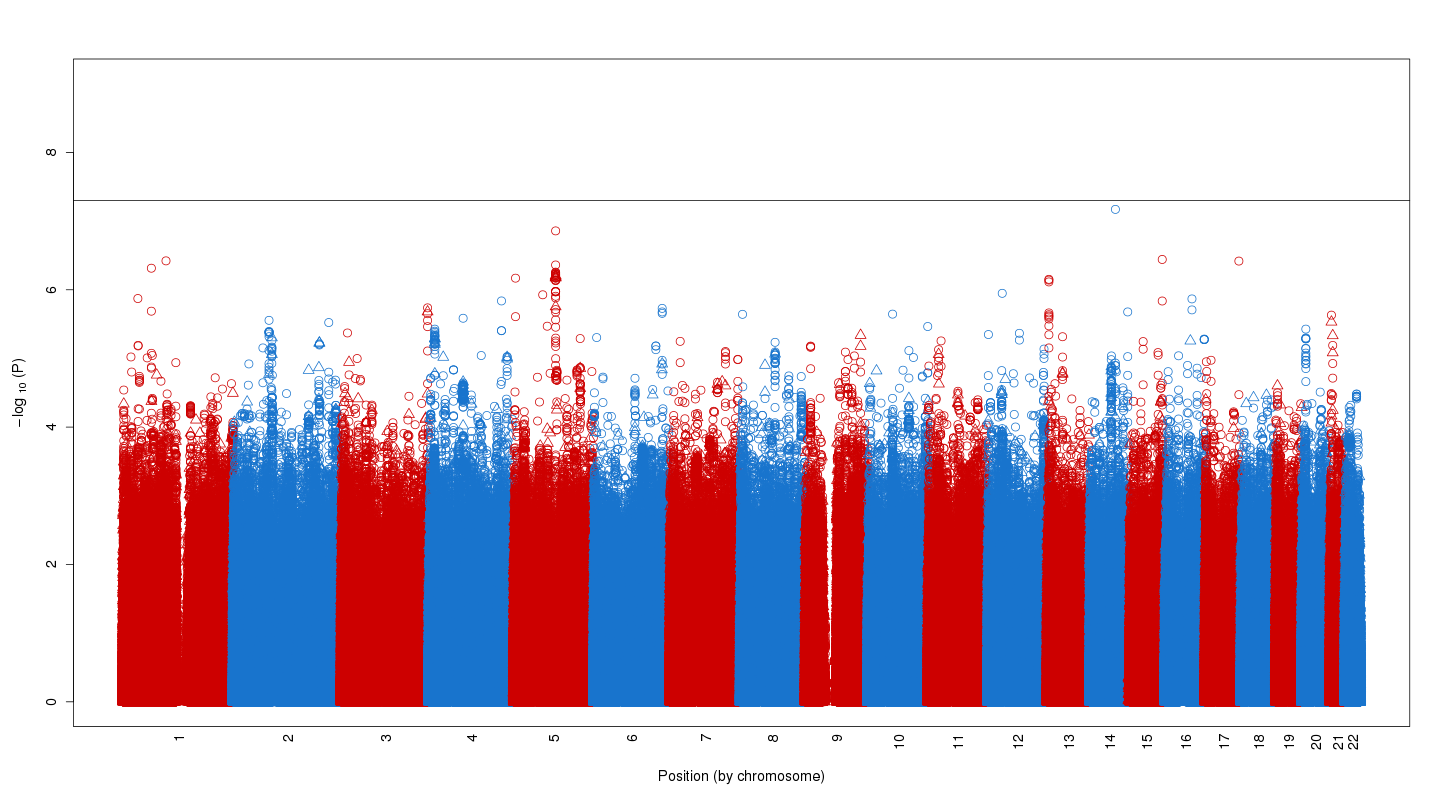

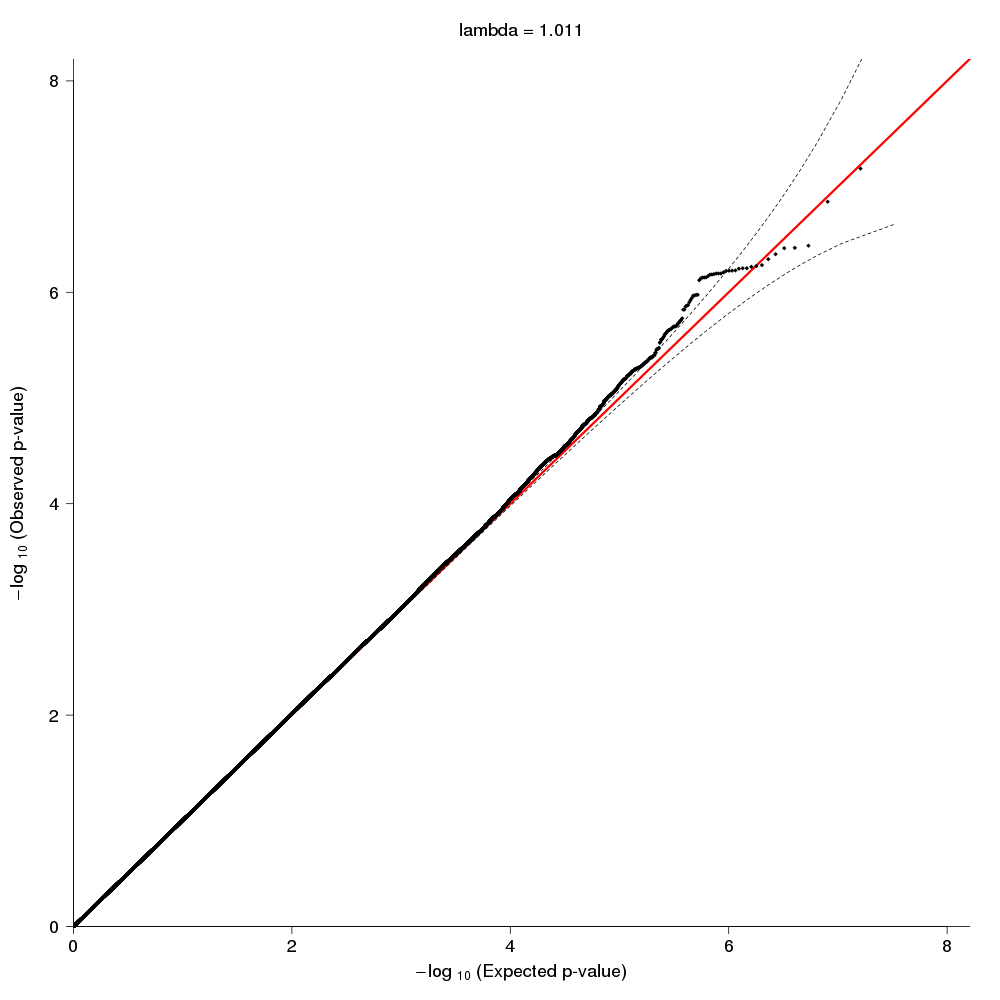

In [17]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/heroin/ngc/kreek/20181113/gwas/aa/kreek.aa.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/heroin/ngc/kreek/20181113/gwas/aa/kreek.aa.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")  

### EA

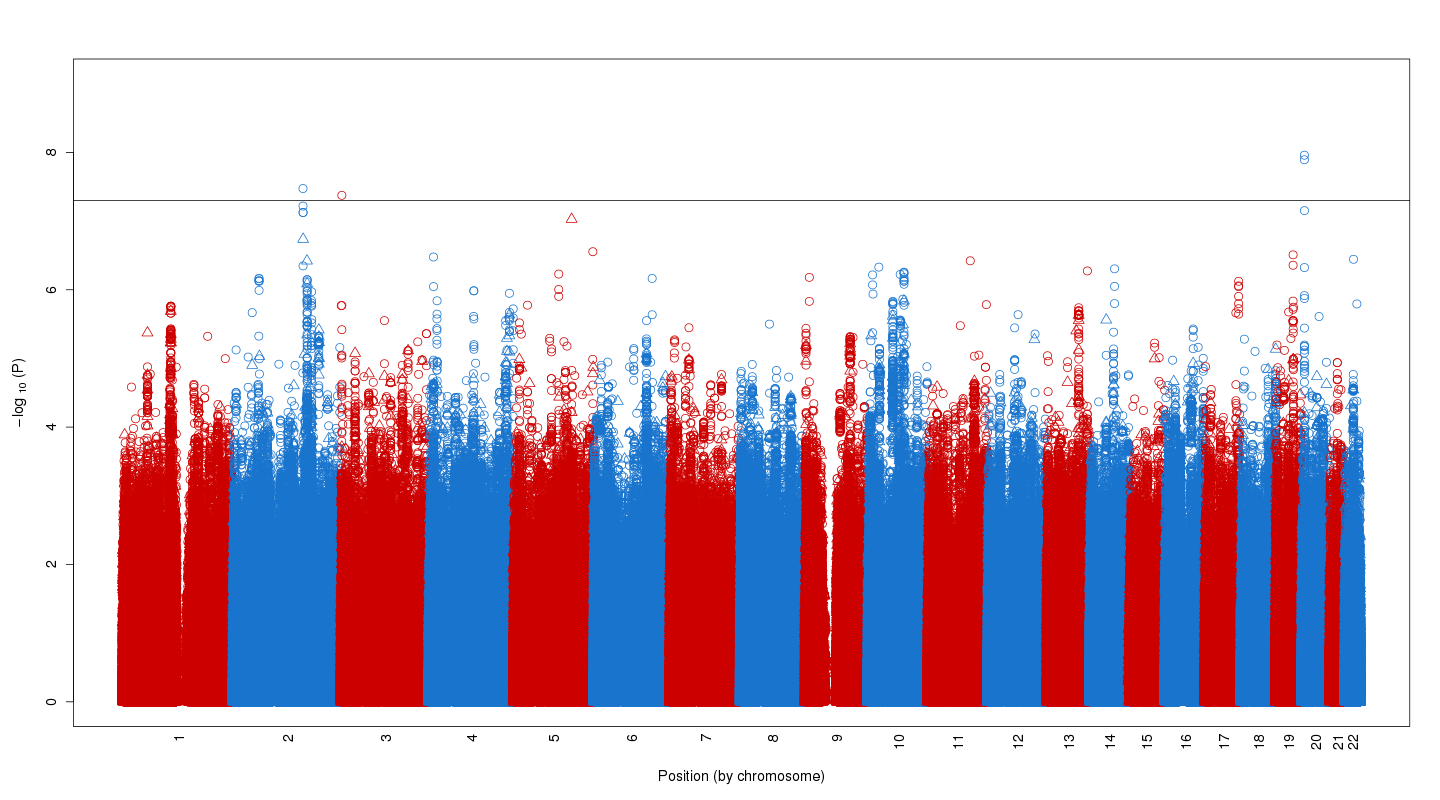

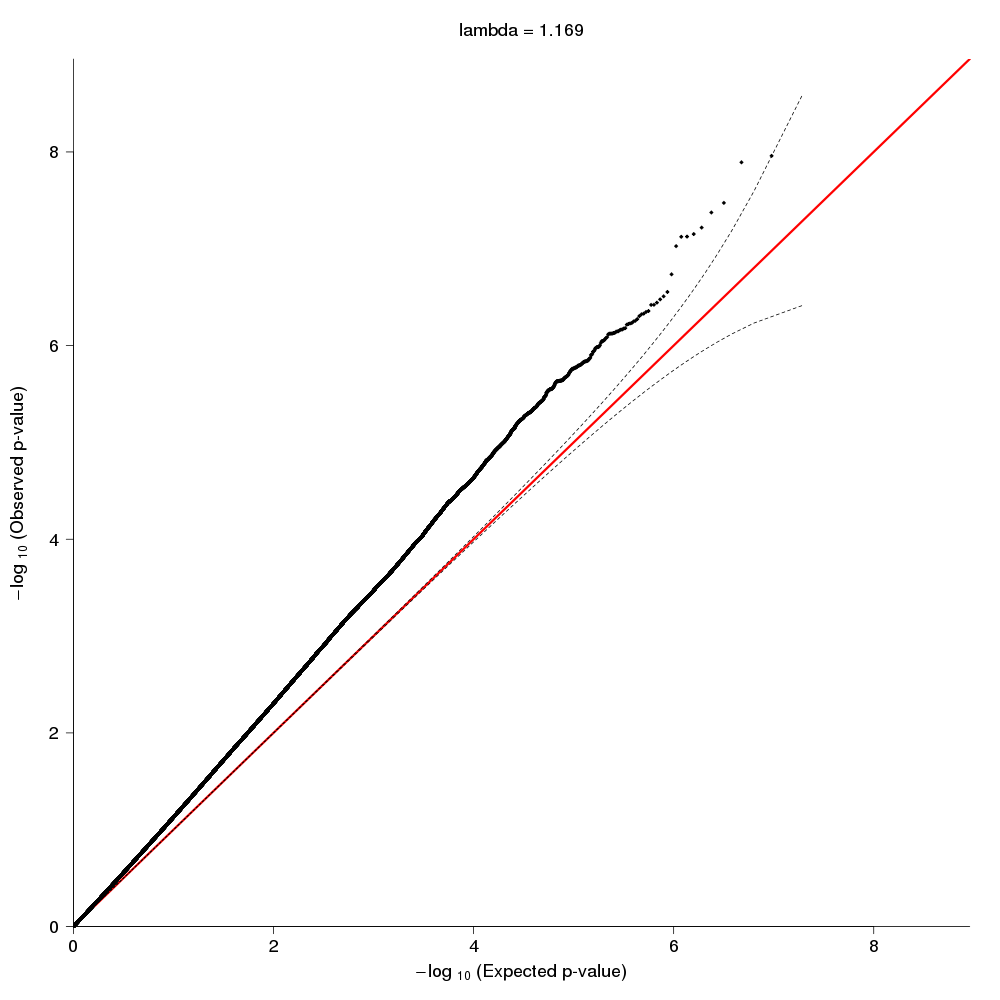

In [16]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181113/gwas/ea/kreek.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181113/gwas/ea/kreek.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")  

Because the lambda value is inflate - indicated possible underlying population structure - we will perform genomic control on the EA group using the METAL software. Specifically, we will perform a meta-analysis using METAL with the Kreek EAs as the only cohort and apply genomic control.

## Apply Genomic Control to EAs
First I need to prepend the `MARKERNAME` column to the GWAS results

In [ ]:

# take off headers except for header row with column identifiers
# adding a dummy column for now which will be converted to 1000Gp3
# with the convert_to_1000g_ids perl script
for chr in {1..22};do
    myDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea/processing/chr$chr
    zcat $myDir/*gz | tail -n +31 > $myDir/kreek.tmp
    awk '{ print "MARKERNAME",$0 }' $myDir/kreek.tmp > $myDir/kreek.ea.1000G_p3.gwas.results
done

# convert to 1000g
for chr in {1..22};do
    myDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea/processing/chr$chr

    perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in $myDir/kreek.ea.1000G_p3.gwas.results\
        --file_out $myDir/tmp\
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz\
        --file_in_id_col 0\
        --file_in_chr_col 1\
        --file_in_pos_col 2\
        --file_in_a1_col 3\
        --file_in_a2_col 4\
        --chr $chr
    awk ' { if (NR==1) {$1 = "MARKERNAME"}} {print $0}' $myDir/tmp > $myDir/kreek.ea.1000G_p3.gwas.results
    rm $myDir/tmp $myDir/kreek.ea.1000G_p3.gwas.results $myDir/kreek.tmp
done &

# add a SE column
for chr in {1..22};do
    myDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea/processing/chr$chr
    awk '{ print $0,"SE" }' $myDir/kreek.ea.1000G_p3.gwas.results >\
        $myDir/tmp && mv $myDir/tmp $myDir/kreek.ea.1000G_p3.gwas.results
done &

for chr in {1..22};do
    cp chr$chr/kreek.ea.1000G_p3.se.gwas.results chr$chr/kreek.ea.1000G_p3.gwas.results
    awk '{$18="";print $0}' chr$chr/kreek.ea.1000G_p3.gwas.results >\
        chr$chr/tmp && mv chr$chr/tmp chr$chr/kreek.ea.1000G_p3.gwas.results
done &


# processing the se files, note that if there are NAs in the
# SQRT_V_STAT column just set the SE to NA
for chr in {1..22};do
    awk ' NR>=2\
            { if ( $15=="NA" ) \
                 $18="NA";\
              else\
                 $18=1/$15;\
            }\
        {print $0}' chr$chr/kreek.ea.1000G_p3.se.gwas.results >\
                    chr$chr/tmp && mv chr$chr/tmp chr$chr/kreek.ea.1000G_p3.se.gwas.results
done

# clean up directory
for chr in {1..22};do
    #mv chr$chr/kreek.ea.1000G_p3.se.gwas.results chr$chr/kreek.ea.1000G_p3.chr$chr.se.gwas.results
    #rm chr$chr/kreek.ea.1000G_p3.se.gwas.results
    rm chr$chr/kreek.ea.1000G.gwas.results
done

**Note** I had to update the `qsub_metal` script to recognize the updated paths when switching from the MIDAS computing platform to AWS. The parallel computing environment was update from ORTE to XXXX as well.

In [ ]:
myDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea
mkdir -p $myDir/genomic_control/{processing,final,test}
myCohorts=kreek_ea.eur

#for (( chr=1; chr<23; chr++)); do
chr=22
  /shared/bioinformatics/software/scripts/qsub_metal_v02.sh \
    --SCHEME STDERR \
    --MARKER MARKERNAME \
    --ALLELE A1 A2 \
    --EFFECT ALT_EFFSIZE \
    --PVALUE PVALUE \
    --STDERR SE \
    --GENOMICCONTROL ON \
        --PROCESS $myDir/processing/chr$chr.test/kreek.ea.1000G_p3.chr$chr.se.gwas.results \
        --OUTFILE $myDir/genomic_control/test2/$myCohorts.chr$chr.1df .metal \
    --ANALYZE HETEROGENEITY \
    --script_prefix $myDir/genomic_control/test2/$myCohorts.chr$chr.1df \
    --mem 3.8 \
    --nslots 1 \
    --priority 0
done


myDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea
myCohorts=kreek_ea.eur

### START Merge ProbABEL and METAL results ###
#for (( chr=1; chr<23; chr++ )); do
#chr=22
#  /shared/bioinformatics/software/scripts/qsub_job.sh \
#    --job_name meta_${chr} \
#    --script_prefix $myDir/processing/$myCohorts.chr$chr.1df \
#    --mem 15 \
#    --priority 0 \
#    --program Rscript /shared/bioinformatics/software/R/merge_probabel_metal.R \
#        --metal $myDir/genomic_control/processing/$myCohorts.chr$chr.1df.metal \
#        --probabel $myDir/processing/chr$chr/kreek.ea.1000G_p3.chr$chr.se.gwas.results \
#        --chr_columns 2 \
#        --pos_columns 3 \
#        --probabel_merge_bys SE \
#        --probabel_labels KREEK_EA \
#        --out $myDir/genomic_control/final/$myCohorts.chr$chr.probabel.merged.metal.results.1df
#done


# note that I probably should use one of the python merge scripts that is still on MIDAS. 
# They seem to do what I want.


myDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea
myCohorts=kreek_ea.eur

chr=22
  /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name meta_${chr} \
    --script_prefix $myDir/processing/$myCohorts.chr$chr.1df \
    --mem 15 \
    --priority 0 \
    --program python ~/*py \
        --metal $myDir/genomic_control/processing/$myCohorts.chr$chr.1df.metal \
        --probabel $myDir/processing/chr$chr/kreek.ea.1000G_p3.chr$chr.se.gwas.results \
        --probabel_labels KREEK_EA \
        --out $myDir/genomic_control/final/$myCohorts.chr$chr.probabel.merged.metal.results.1df
done

# Potential issues with METAL (resolved)


`The potential issue with METAL is explained below.` We have since solved the conundrum. In short, METAL handles the flipping of the alleles different from what I one would expect after reading their [alternative instruction file](http://csg.sph.umich.edu/abecasis/METAL/metal-instructions.pdf). The explanation for how METAL actually handles the flipping of the alleles is explained [in this GitHub Issue](https://github.com/Nealelab/ricopili/issues/55). 


From what I can tell, the `Allele1` and `Allele2` outputs from METAL are sometimes opposite of what it should be. Adhoc example, `InputA1 = A` & `InputA2 = C` but `OutputA1 = C` & `OutputA2 = A`. When flipping of the alleles occurs, the beta is flipped (from positive to negative || vice versa). When the output `Allele1` and `Allele2` are in concordance with the input alleles then the output beta is in the correct direction - i.e. the same direction as the input beta. 

* Why does this happen?

## with --ALLELE REF ALT

** head /shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea/genomic_control/processing/kreek_ea.eur.chr22.1df.metal**
```
MarkerName      Allele1 Allele2 Effect  StdErr  P-value Direction       HetISq  HetChiSq        HetDf   HetPVal
rs368712549:25955830:C:T        t       c       -62.3493        43.3745 0.1506  -       0.0     0.000   0       1
rs77984742:33786382:C:T t       c       -1.6464 4.3573  0.7055  -       0.0     0.000   0       1
22:44524532:C:A a       c       201.5220        123.2992        0.1022  +       0.0     0.000   0       1
rs146476801:31083131:C:T        t       c       -1.0409 10.8151 0.9233  -       0.0     0.000   0       1
22:26205770:T:C t       c       -155.0640       134.5980        0.2493  -       0.0     0.000   0       1
rs12160960:28067205:T:C t       c       0.0034  0.0822  0.9671  +       0.0     0.000   0       1
```

<bl>
**grep rs368712549:25955830:C:T ../../processing/chr22/kreek.ea.1000G_p3.chr22.se.gwas.results**
```
MARKERNAME CHROM POS REF ALT N_INFORMATIVE AF INFORMATIVE_ALT_AC CALL_RATE HWE_PVALUE N_REF N_HET N_ALT U_STAT SQRT_V_STAT ALT_EFFSIZE PVALUE SE
    
rs368712549:25955830:C:T 22 25955830 C T 624 0.00011859 0.148 1 1 624 0 0 0.0376685 0.0245795 62.3493 0.125395 40.6843
    
rs77984742:33786382:C:T 22 33786382 C T 624 0.000988782 1.234 1 1 624 0 0 0.0985617 0.244675 1.64637 0.687076 4.08705
    
22:44524532:C:A 22 44524532 C A 624 3.6859e-05 0.046 1 1 624 0 0 -0.0150666 0.00864663 -201.522 0.0814233 115.652
    
rs146476801:31083131:C:T 22 31083131 C T 624 0.000698718 0.872 1 1 624 0 0 0.0101148 0.098578 1.04088 0.918274 10.1443
22:26205770:T:C 22 26205770 T C 624 4.64744e-05 0.058 1 1 624 0 0 -0.0097286 0.00792081 -155.064 0.21936 126.25
rs12160960:28067205:T:C 22 28067205 T C 624 0.169362 211.364 1 0.314938 436 167 21 0.570633 12.9654 0.00339456 0.964895 0.0771284
```

## with --ALLELE ALT REF
** head /shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea/genomic_control/test/kreek_ea.eur.chr22.1df.metal**

```
MarkerName      Allele1 Allele2 Effect  StdErr  P-value Direction       HetISq  HetChiSq        HetDf   HetPVal
rs368712549:25955830:C:T        t       c       62.3493 43.3745 0.1506  +       0.0     0.000   0       1
rs77984742:33786382:C:T t       c       1.6464  4.3573  0.7055  +       0.0     0.000   0       1
22:44524532:C:A a       c       -201.5220       123.2992        0.1022  -       0.0     0.000   0       1
rs146476801:31083131:C:T        t       c       1.0409  10.8151 0.9233  +       0.0     0.000   0       1
rs12160960:28067205:T:C t       c       -0.0034 0.0822  0.9671  -       0.0     0.000   0       1
```


<bl>
**grep rs368712549:25955830:C:T ../../processing/chr22/kreek.ea.1000G_p3.chr22.se.gwas.results**
```
MARKERNAME CHROM POS REF ALT N_INFORMATIVE AF INFORMATIVE_ALT_AC CALL_RATE HWE_PVALUE N_REF N_HET N_ALT U_STAT SQRT_V_STAT ALT_EFFSIZE PVALUE SE
    
rs368712549:25955830:C:T 22 25955830 C T 624 0.00011859 0.148 1 1 624 0 0 0.0376685 0.0245795 62.3493 0.125395 40.6843
    
rs77984742:33786382:C:T 22 33786382 C T 624 0.000988782 1.234 1 1 624 0 0 0.0985617 0.244675 1.64637 0.687076 4.08705
    
22:44524532:C:A 22 44524532 C A 624 3.6859e-05 0.046 1 1 624 0 0 -0.0150666 0.00864663 -201.522 0.0814233 115.652
    
rs146476801:31083131:C:T 22 31083131 C T 624 0.000698718 0.872 1 1 624 0 0 0.0101148 0.098578 1.04088 0.918274 10.1443
rs12160960:28067205:T:C 22 28067205 T C 624 0.169362 211.364 1 0.314938 436 167 21 0.570633 12.9654 0.00339456 0.964895 0.0771284
```

### sandbox

In [ ]:
BASE_DIR = '/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea/genomic_control/test2/'
inF = open(BASE_DIR + 'kreek_ea.eur.chr22.1df.metal')

inF.readline() 
line = inF.readline()
concordance = 0
discordance = 0
while(line):
    actual_allele1 = line.split()[0].split(":")[2]
    supposed_allele1 = line.split()[1].capitalize()
    if actual_allele1 == supposed_allele1:
        concordance += 1
    else:
        discordance += 1
    line = inF.readline()
print("concordance count of %s", concordance)
print("discordance count of %s", discordance)

# Upload results to S3

In [ ]:
aaFinalDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/aa/final
aaResultsDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/aa/processing

eaFinalDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea/final
eaResultsDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/association_tests/001/ea/processing

# gzip all results files
for chr in {1..22};do
    gzip $eaFinalDir/* $aaFinalDir/*
    gzip $aaResultsDir/chr$chr/* $eaResultsDir/chr$chr/*
done &

# upload GWAS results aa & ea
aws s3 sync $aaFinalDir s3://rti-heroin/kreek/results/aa/  --quiet &
aws s3 sync $eaFinalDir s3://rti-heroin/kreek/results/ea/ --quiet &
aws s3 sync $eaResultsDir s3://rti-heroin/kreek/results/ea/ --quiet &
aws s3 sync $aaResultsDir s3://rti-heroin/kreek/results/aa/ --quiet &

# upload GC applied GWAS results ea
aws s3 sync $eaFinalDir/../genomic_control/processing s3://rti-heroin/kreek/results/ea/genomic_control --quiet &

# upload phenotype data
phenoDir=/shared/bioinformatics/jmarks/heroin/kreek/gwas/oaall/data/phenotype
aws s3 cp $phenoDir/phs001109.v1.pht005447.v1.p1.c1.Addictive_Diseases_Subject_Phenotypes.DS-ADX-IRB-NPU.txt s3://rti-heroin/kreek/data/phenotype/phs001109.v1.pht005447.v1.p1.c1.Addictive_Diseases_Subject_Phenotypes.DS-ADX-IRB-NPU.txt
aws s3 cp $phenoDir/phs001109.v1.pht005445.v1.p1.Addictive_Diseases_Subject.MULTI.txt s3://rti-heroin/kreek/data/phenotype/phs001109.v1.pht005445.v1.p1.Addictive_Diseases_Subject.MULTI.txt
aws s3 sync $phenoDir/final s3://rti-heroin/kreek/data/phenotype/final/
